<a href="https://colab.research.google.com/github/shufan6011/ML-Projects/blob/main/Step_2_Basic_GW_Data_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, os
from scipy.signal import butter, filtfilt, spectrogram
from sklearn.preprocessing import StandardScaler


In [ ]:
# Go to https://gwosc.org
# Find the information required below (GPS time & detector)


In [ ]:
# Set a GPS time:
t_start = 1126259462.4
t_end = 1126259462.4 # For specific events, make t_end the same as t_start

# Choose detector as H1, L1, or V1
detector = 'H1'


In [ ]:
%config InlineBackend.figure_format = 'retina'

try:
    from gwpy.timeseries import TimeSeries
except:
    ! pip install -q "gwpy==3.0.8"
    ! pip install -q "matplotlib==3.9.0"
    ! pip install -q "astropy==6.1.0"
    from gwpy.timeseries import TimeSeries


In [ ]:
from gwosc.locate import get_urls
url = get_urls(detector, t_start, t_end)[-1]

print('Downloading: ' , url)
fn = os.path.basename(url)
with open(fn,'wb') as strainfile:
    straindata = requests.get(url)
    strainfile.write(straindata.content)


Downloading:  http://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


In [ ]:
# Read strain data
strain = TimeSeries.read(fn,format='hdf5.gwosc')

# Examine an interval of the event closely
# center = int(t_start)
# strain = strain.crop(center-0.2, center+0.1)

# Extract timestamps and strain values
timestamps = strain.times.value
strain_values = strain.value

# Store the data in a Pandas DataFrame
data = pd.DataFrame({
    'time': timestamps,
    'strain': strain_values
})


## Handling Missing Values

In [ ]:
# Drop rows with missing values
data = data.dropna()

print("\nMissing values after cleaning:")
print(data.isnull().sum())



Missing values after cleaning:
time      0
strain    0
dtype: int64


## Data Noise Filtering

In [ ]:
# Band-pass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    try:
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    try:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = filtfilt(b, a, data)
        return y
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Filter parameters
lowcut = 20  # Low cutoff frequency (Hz)
highcut = 500  # High cutoff frequency (Hz)

# Apply band-pass filter to the strain data
data['strain'] = bandpass_filter(data['strain'], lowcut, highcut, 4096)


## Data Normalization

In [ ]:
# Normalize the filtered strain data
scaler = StandardScaler()
data['strain'] = scaler.fit_transform(data[['strain']])


## Data Inspection

In [ ]:
# Inspect the first few rows
print("First few rows of the data:")
print(data.head())

# Inspect col headers
print("\nCol headers:")
print(data.columns)

# Summary stats
print("\nSummary stats:")
print(data.describe())

# Check for missing vals
print("\nMissing vals in each col:")
print(data.isnull().sum())

# Check the sampling frequency
print(f"Sampling frequency: {strain.sample_rate} Hz")
fs = 4096 # Change this if sampling frequency is different


First few rows of the data:
           time    strain
0  1.126257e+09 -2.509170
1  1.126257e+09  0.070279
2  1.126257e+09  2.209691
3  1.126257e+09  3.618610
4  1.126257e+09  4.256309

Col headers:
Index(['time', 'strain'], dtype='object')

Summary stats:
               time        strain
count  1.677722e+07  1.677722e+07
mean   1.126259e+09 -1.758737e-17
std    1.182413e+03  1.000000e+00
min    1.126257e+09 -3.686864e+00
25%    1.126258e+09 -7.088868e-01
50%    1.126259e+09  1.167451e-03
75%    1.126260e+09  7.087773e-01
max    1.126262e+09  4.284804e+00

Missing vals in each col:
time      0
strain    0
dtype: int64
Sampling frequency: 4096.0 Hz Hz


# Time Series Plot

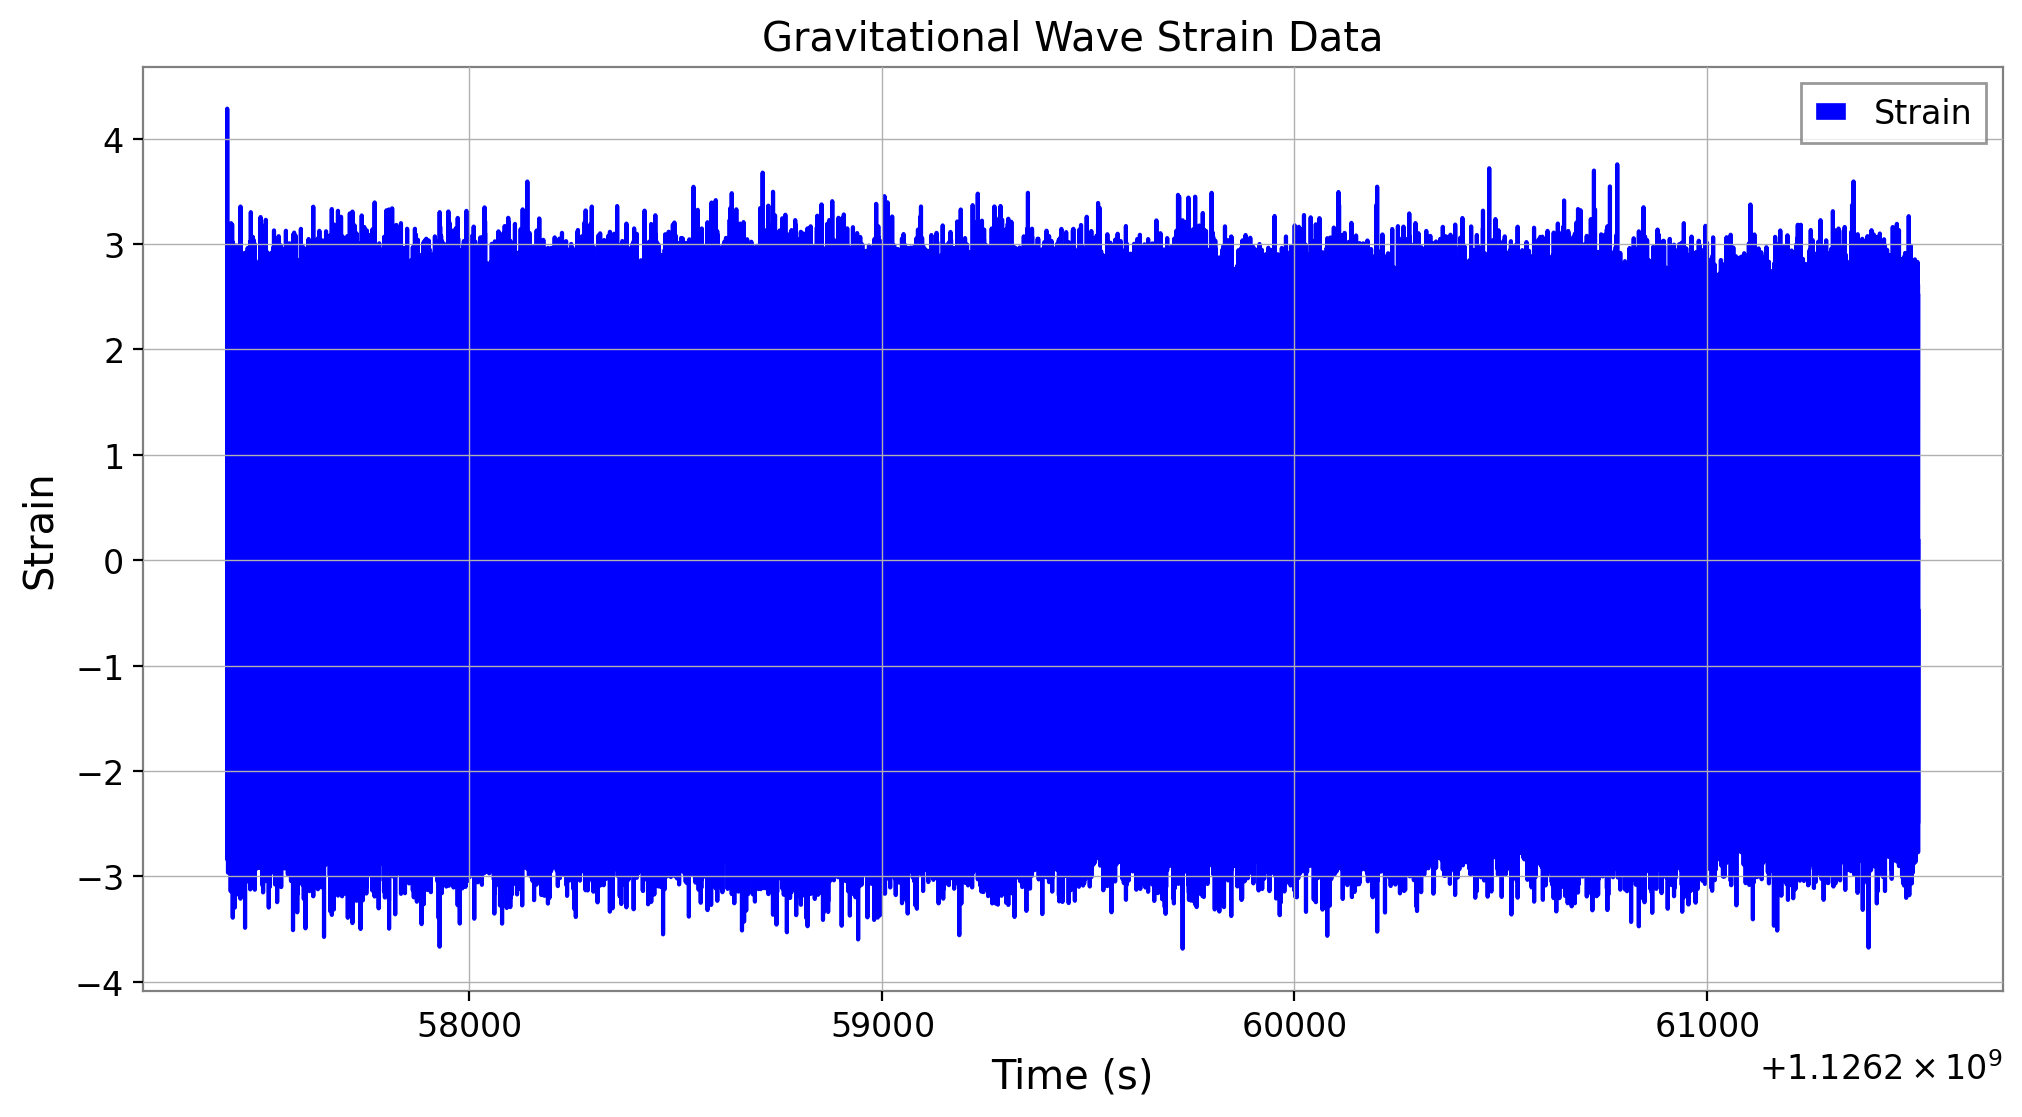

In [ ]:
def plot_strain_data(time, strain, label, ylabel, title, color='blue', figsize=(12, 6)):
    try:
        plt.figure(figsize=figsize)
        plt.plot(time, strain, label=label, color=color)
        plt.xlabel('Time (s)')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Plot strain data
plot_strain_data(data['time'], data['strain'],
                 label='Strain', ylabel='Strain',
                 title='Gravitational Wave Strain Data')


# Spectrogram

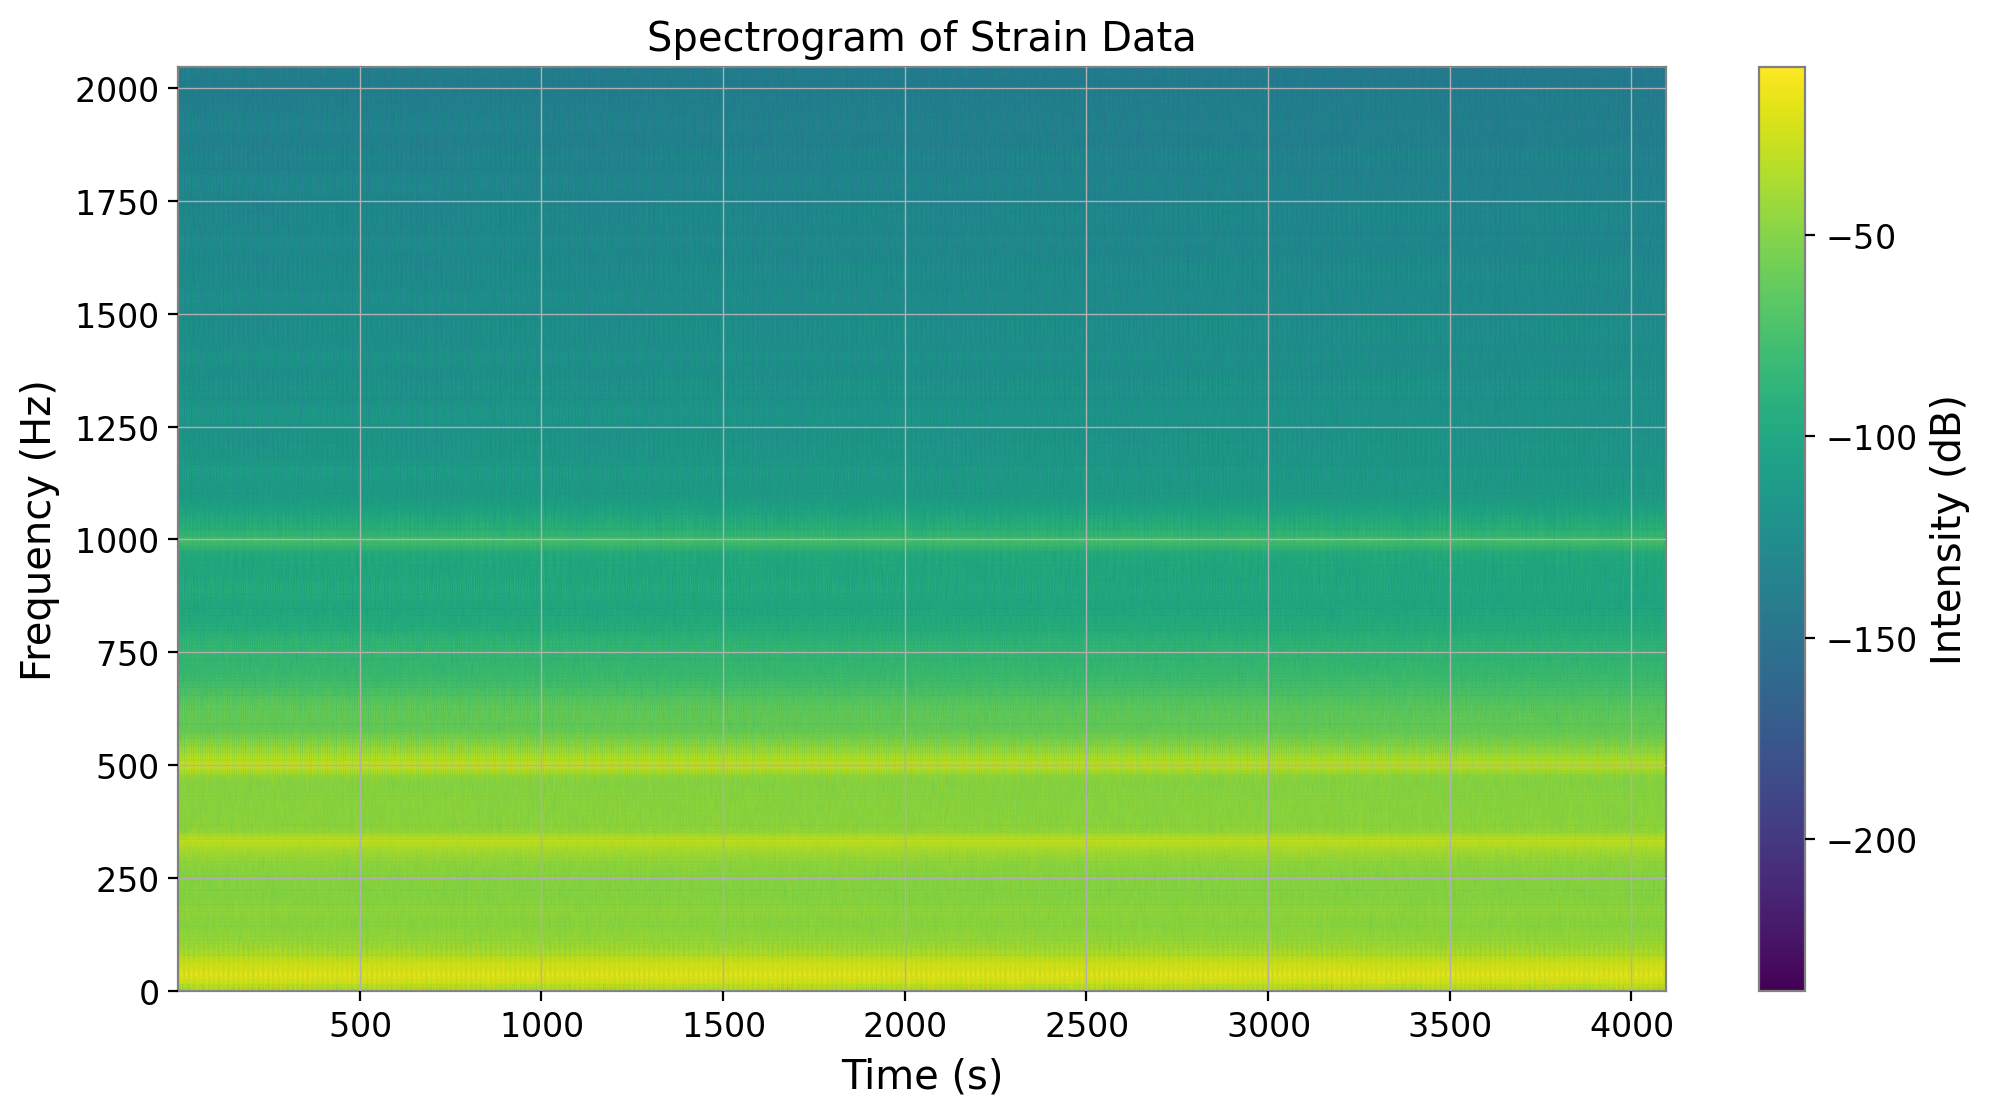

In [ ]:
def compute_and_plot_spectrogram(data, fs, title):
    try:
        frequencies, times, Sxx = spectrogram(data, fs)
        plt.figure(figsize=(12, 6))
        plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
        plt.colorbar(label='Intensity (dB)')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(title)
        plt.show()
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Compute and plot the spectrogram for strain data
compute_and_plot_spectrogram(data['strain'], fs, 'Spectrogram of Strain Data')


# Histogram

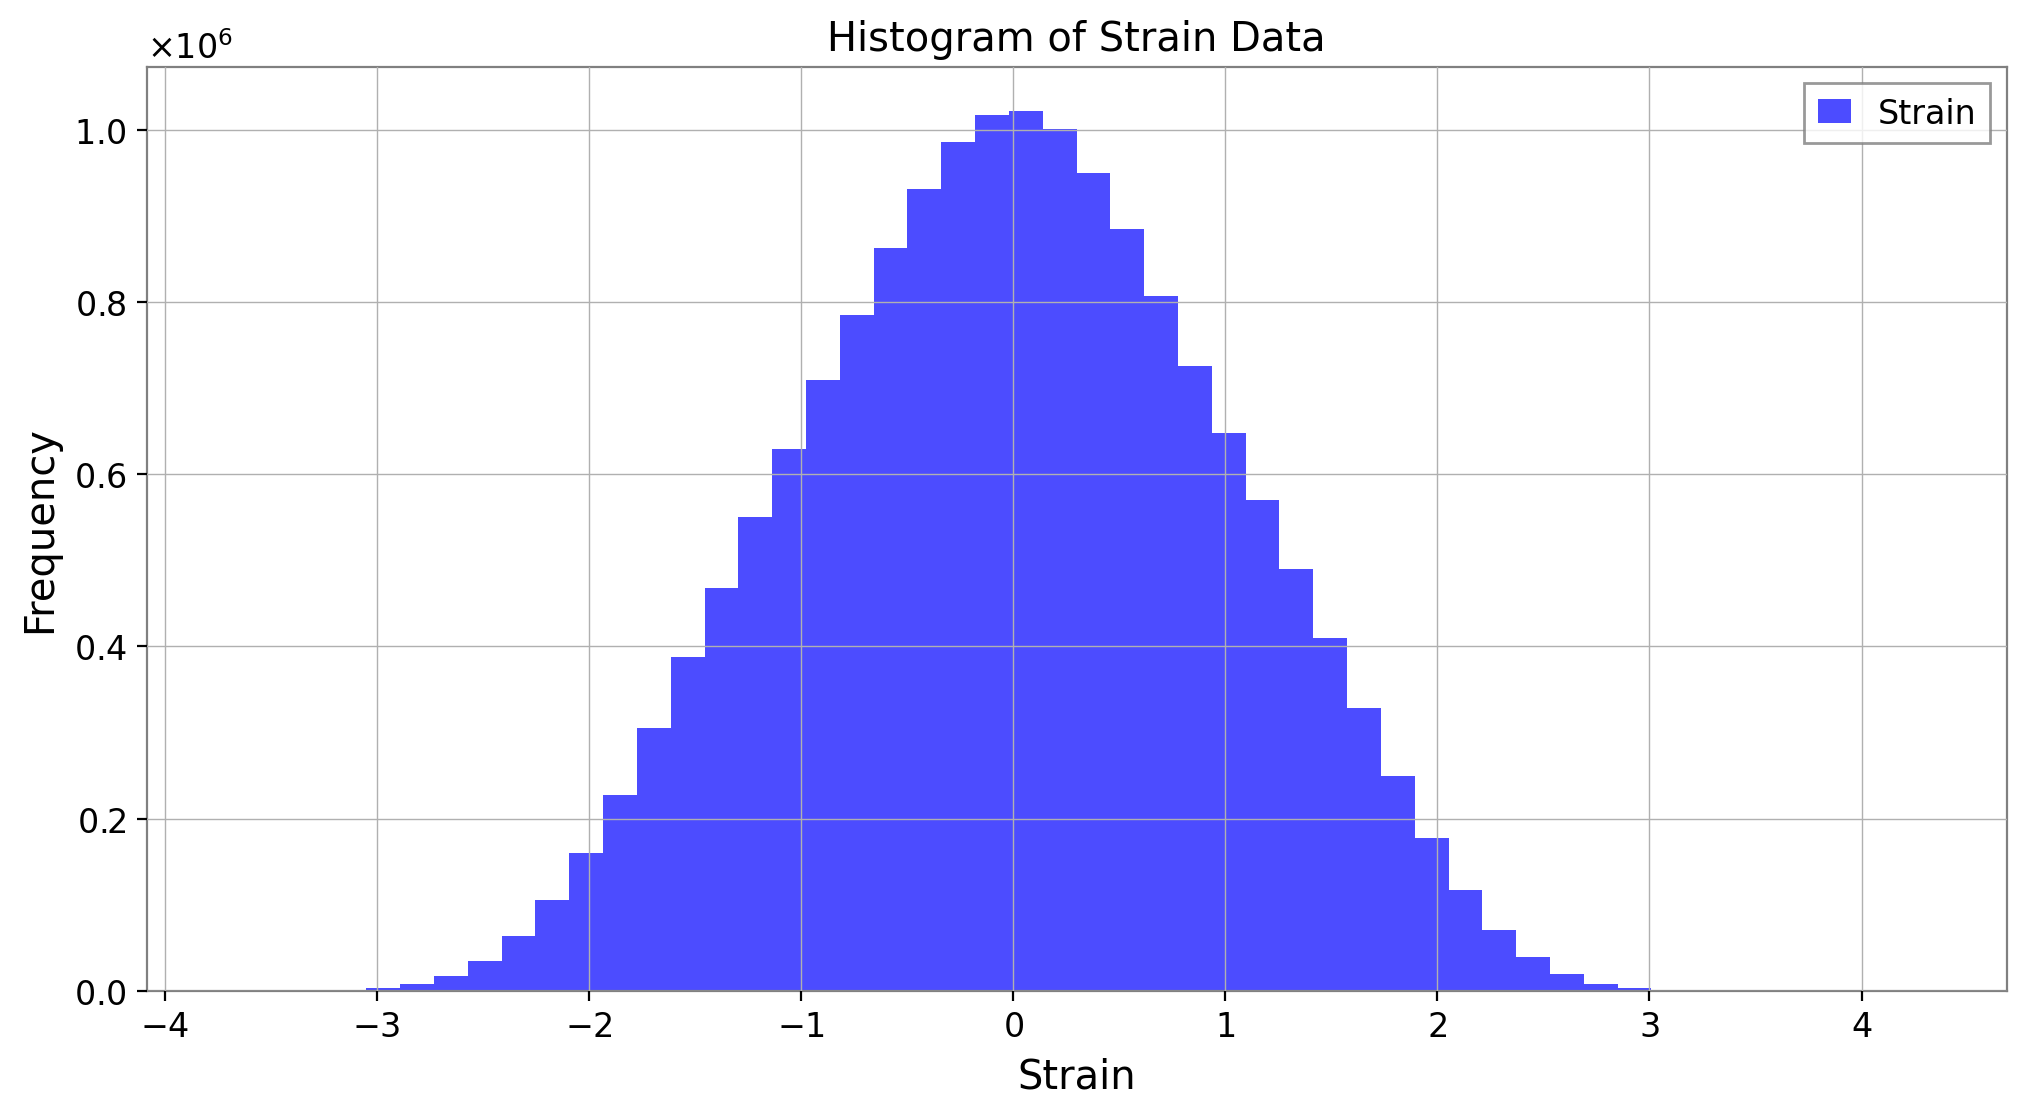

In [ ]:
def plot_histogram(data, bins, xlabel, title, label, color='blue', figsize=(12, 6)):
    try:
        plt.figure(figsize=figsize)
        plt.hist(data, bins=bins, alpha=0.7, color=color, label=label)
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.title(title)
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Plot histogram of the strain data
plot_histogram(data['strain'], bins=50, xlabel='Strain',
               title='Histogram of Strain Data', label='Strain')
